## Simulation as Optimization: Finding Paths of Least Action with Gradient Descent
Tim Strang and Sam Greydanus | 2023 | MIT License

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, time

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from main import * # SimOpt code

In [110]:
def plot_action_stats(ax, S, T, V, S_ode, T_ode, V_ode):
    plot_config = [(S, 'k', '$S$'), (T, 'r', '$\sum_i T_i$'), (-np.asarray(V), 'b', '$-\sum_i V_i$'),
                   (S_ode, 'k--', '$S$ (ODE)'), (T_ode, 'r--', '$-\sum_i T_i$ (ODE)'),
                   (-V_ode, 'b--', '$-\sum_i V_i$ (ODE)')]
    N = len(S)
    for i, (x, fmt, label) in enumerate(plot_config):
        if i <= 2:
            ax.plot(np.arange(N), x, fmt, linewidth=4, label=label)
        else:
            ax.plot([0,N], [x]*2, fmt, linewidth=4, label=label)
            
def plot_helper(ax, ax_labels):
    plt.title(ax_labels['title'], fontweight="bold")
    plt.legend(ncol=2)
    plt.xlabel(ax_labels['x_label'])
    plt.ylabel(ax_labels['y_label'])
    for item in [ax.xaxis.label, ax.yaxis.label]:
        item.set_fontsize(23)
    ax.title.set_fontsize(19)
    ax.tick_params(axis='both', length=9, width=3, labelsize=15)
    plt.tight_layout()  # helps clean up plots sometimes
    
def action_plot(info, x_sim, ax_labels, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(8.3333, 6.25), dpi=50)
    ax = fig.add_subplot(111)
    S_ode, T_ode, V_ode = action(torch.from_numpy(x_sim), L_fn=lagrangian_freebody, dt=dt)
    plot_action_stats(ax, info['S'], info['T'], info['V'], S_ode, T_ode, V_ode)

    plot_helper(ax, ax_labels)
    return fig

## Free body

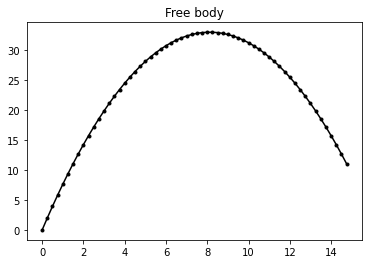

In [111]:
t_sim, x_sim = simulate_freebody(dt=0.25, steps=60)
plt.title('Free body')
plt.plot(t_sim, x_sim, 'k.-')
plt.show()

In [123]:
dt = 0.25 ; N = 1 ; steps = 60
t_sim, x_sim = simulate_freebody(dt=dt, steps=steps)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e0, 
                                       L_fn=lagrangian_freebody, dt=dt, opt='adam')

step=0000, S=5.464e+01 J*s, dt=0.0s
step=0033, S=-1.036e+00 J*s, dt=0.0s
step=0066, S=-4.900e+00 J*s, dt=0.0s
step=0099, S=-7.694e+00 J*s, dt=0.0s
step=0132, S=-9.885e+00 J*s, dt=0.0s
step=0165, S=-1.147e+01 J*s, dt=0.0s
step=0198, S=-1.254e+01 J*s, dt=0.0s
step=0231, S=-1.320e+01 J*s, dt=0.0s
step=0264, S=-1.358e+01 J*s, dt=0.0s
step=0297, S=-1.379e+01 J*s, dt=0.0s
step=0330, S=-1.390e+01 J*s, dt=0.0s
step=0363, S=-1.395e+01 J*s, dt=0.0s
step=0396, S=-1.397e+01 J*s, dt=0.0s
step=0429, S=-1.398e+01 J*s, dt=0.0s
step=0462, S=-1.399e+01 J*s, dt=0.0s
step=0495, S=-1.399e+01 J*s, dt=0.0s


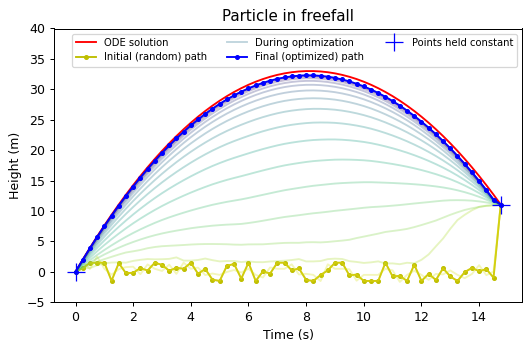

In [124]:
plt.figure(dpi=90)
plt.title('Particle in freefall')
plt.plot(t_sim, x_sim, 'r-', label='ODE solution')

plt.plot(t_min, xs_min[0], 'y.-', label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    plt.plot(t_min, xi, alpha=0.3, color=plt.cm.viridis( 1-i/(len(xs_min)-1) ), label=label)
plt.plot(t_min, xs_min[-1], 'b.-', label='Final (optimized) path')
plt.plot(t_min[[0,-1]], xs_min[0].data[[0,-1]], 'b+', markersize=15, label='Points held constant')

plt.ylim(-5, 40)
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8, ncol=3)
plt.tight_layout() ; plt.show()

./static/freebody_action.pdf


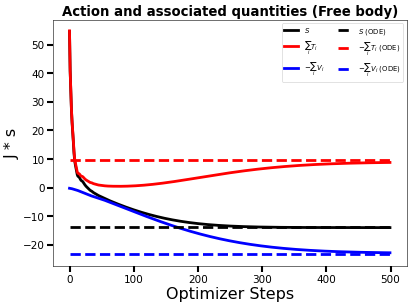

In [125]:
name = 'Free body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Single pendulum

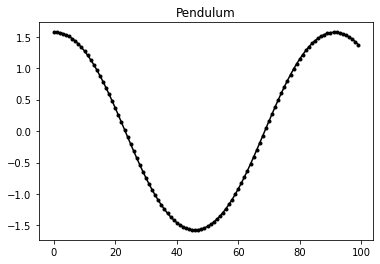

In [126]:
t_sim, x_sim = simulate_pend(dt=1)
plt.title('Pendulum')
plt.plot(t_sim, x_sim, 'k.-')
plt.show()

step=0000, S=2.465e+04 J*s, dt=0.0s
step=0066, S=2.762e+00 J*s, dt=0.0s
step=0132, S=-2.205e+01 J*s, dt=0.0s
step=0198, S=-2.998e+01 J*s, dt=0.0s
step=0264, S=-4.413e+01 J*s, dt=0.0s
step=0330, S=-1.160e+02 J*s, dt=0.0s
step=0396, S=-2.425e+02 J*s, dt=0.0s
step=0462, S=-2.491e+02 J*s, dt=0.0s
step=0528, S=-2.491e+02 J*s, dt=0.0s
step=0594, S=-2.491e+02 J*s, dt=0.0s
step=0660, S=-2.462e+02 J*s, dt=0.0s
step=0726, S=-2.379e+02 J*s, dt=0.0s
step=0792, S=-2.056e+02 J*s, dt=0.0s
step=0858, S=-2.449e+02 J*s, dt=0.0s
step=0924, S=-2.491e+02 J*s, dt=0.0s
step=0990, S=-2.491e+02 J*s, dt=0.0s


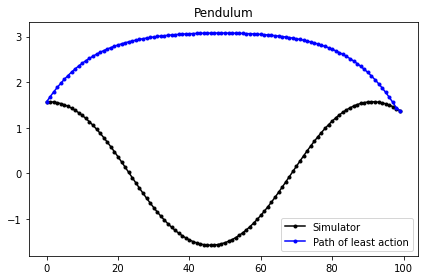

In [127]:
dt = 1 ; N = 1
t_sim, x_sim = simulate_pend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=1000, step_size=1e0, 
                                       L_fn=lagrangian_pend, dt=dt, opt='adam')

plt.title('Pendulum')
plt.plot(t_sim, x_sim, 'k.-', label='Simulator')
plt.plot(t_min, xs_min[-1], 'b.-', label='Path of least action')
plt.legend()
plt.tight_layout() ; plt.show()

./static/freebody_action.pdf


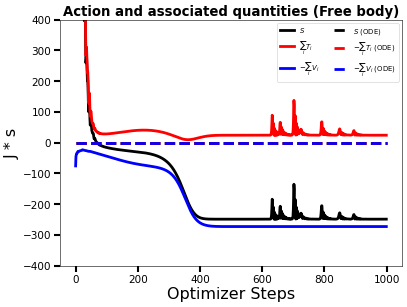

In [128]:
name = 'Free body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels)
plt.ylim(-400, 400)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Double pendulum

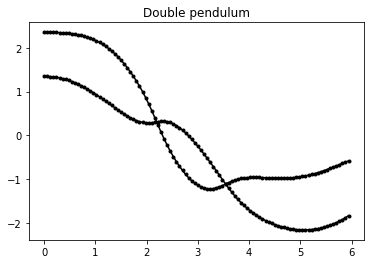

In [129]:
t_sim, x_sim = simulate_dblpend(dt=0.06)
plt.title('Double pendulum')
plt.plot(t_sim, x_sim, 'k.-')
plt.show()

make_video(radial2cartesian(x_sim), path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

step=0000, S=3.988e+02 J*s, dt=0.0s
step=0006, S=5.812e+01 J*s, dt=0.0s
step=0012, S=2.508e+01 J*s, dt=0.0s
step=0018, S=1.987e+01 J*s, dt=0.0s
step=0024, S=1.401e+01 J*s, dt=0.0s
step=0030, S=7.368e+00 J*s, dt=0.0s
step=0036, S=5.685e+00 J*s, dt=0.0s
step=0042, S=4.569e+00 J*s, dt=0.0s
step=0048, S=3.300e+00 J*s, dt=0.0s
step=0054, S=3.018e+00 J*s, dt=0.0s
step=0060, S=2.717e+00 J*s, dt=0.0s
step=0066, S=2.565e+00 J*s, dt=0.0s
step=0072, S=2.497e+00 J*s, dt=0.0s
step=0078, S=2.416e+00 J*s, dt=0.0s
step=0084, S=2.375e+00 J*s, dt=0.0s
step=0090, S=2.340e+00 J*s, dt=0.0s
step=0096, S=2.314e+00 J*s, dt=0.0s


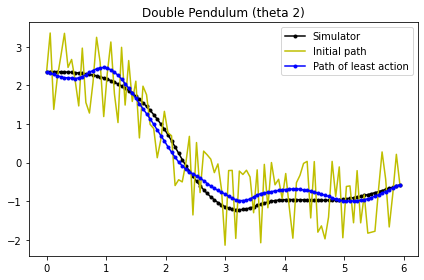

In [132]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1e0, zero_basepath=False) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=100, step_size=1e-1, 
                                       L_fn=lagrangian_dblpend, dt=dt, opt='adam')


plt.title('Double Pendulum (theta 2)')
plt.plot(t_sim, x_sim[:,1], 'k.-', label='Simulator')
plt.plot(t_min, xs_min[0][:,1], 'y-', label='Initial path')
plt.plot(t_min, xs_min[-1][:,1], 'b.-', label='Path of least action')
plt.legend()
plt.tight_layout() ; plt.show()

make_video(radial2cartesian(xs_min[-1]), path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/doublependulum_action.pdf


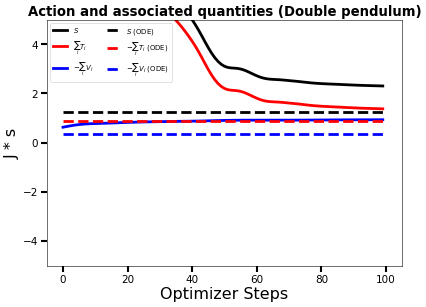

In [136]:
name = 'Double pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels)
plt.ylim(-5, 5)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Three body problem

In [137]:
t, x = simulate_3body()
make_video(x, path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [144]:
dt = 0.5 ; N = 3

t_sim, x_sim = simulate_3body(dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e-2) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=125, step_size=1e1,
                                       L_fn=lagrangian_3body, dt=dt, opt='sgd')

step=0000, S=2.167e-03 J*s, dt=0.0s
step=0008, S=5.537e-04 J*s, dt=0.2s
step=0016, S=5.311e-04 J*s, dt=0.2s
step=0024, S=5.249e-04 J*s, dt=0.3s
step=0032, S=5.219e-04 J*s, dt=0.2s
step=0040, S=5.201e-04 J*s, dt=0.2s
step=0048, S=5.187e-04 J*s, dt=0.2s
step=0056, S=5.176e-04 J*s, dt=0.2s
step=0064, S=5.167e-04 J*s, dt=0.2s
step=0072, S=5.159e-04 J*s, dt=0.2s
step=0080, S=5.151e-04 J*s, dt=0.2s
step=0088, S=5.144e-04 J*s, dt=0.2s
step=0096, S=5.137e-04 J*s, dt=0.2s
step=0104, S=5.131e-04 J*s, dt=0.2s
step=0112, S=5.125e-04 J*s, dt=0.2s
step=0120, S=5.119e-04 J*s, dt=0.2s


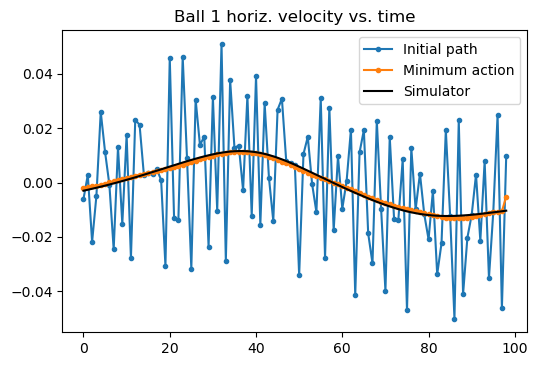

In [145]:
N = x_sim.shape[-2]
xs_before = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_after = xs_min[-1].detach().numpy().reshape(-1,N,2)

plt.figure(dpi=100) ; k = 1
plt.title('Ball {} horiz. velocity vs. time'.format(1 + k//2))
plt.plot((xs_before[1:] - xs_before[:-1]).reshape(-1,N*2)[...,k], '.-', label='Initial path')
plt.plot((xs_after[1:] - xs_after[:-1]).reshape(-1,N*2)[...,k], '.-', label='Minimum action')
plt.plot((x_sim[1:] - x_sim[:-1]).reshape(-1,N*2)[...,k], 'k-', label='Simulator')
plt.legend()
plt.show()

In [146]:
xs = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [147]:
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/threebody_action.pdf


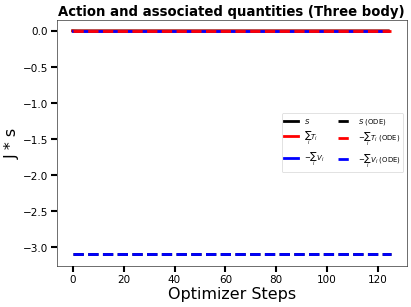

In [151]:
name = 'Three body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels)
# plt.ylim(.1, -.1)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Gas simulation

In [152]:
t, x = simulate_gas(dt=.5, N=50)

make_video(x, path='sim.mp4', interval=30)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [154]:
dt = 0.5 ; N = 50
t_sim, x_sim = simulate_gas(dt=dt, N=N)
init_path = PerturbedPath(x_sim, N=N, sigma=1e-2) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e1,
                                       L_fn=lagrangian_gas, dt=dt, opt='sgd')

step=0000, S=-1.674e-04 J*s, dt=0.0s
step=0033, S=-4.765e-04 J*s, dt=1.6s
step=0066, S=-5.389e-04 J*s, dt=1.5s
step=0099, S=-5.562e-04 J*s, dt=1.6s
step=0132, S=-5.630e-04 J*s, dt=1.6s
step=0165, S=-5.665e-04 J*s, dt=1.6s
step=0198, S=-5.686e-04 J*s, dt=1.6s
step=0231, S=-5.701e-04 J*s, dt=1.5s
step=0264, S=-5.713e-04 J*s, dt=1.5s
step=0297, S=-5.722e-04 J*s, dt=1.6s
step=0330, S=-5.729e-04 J*s, dt=1.6s
step=0363, S=-5.736e-04 J*s, dt=1.6s
step=0396, S=-5.741e-04 J*s, dt=1.5s
step=0429, S=-5.747e-04 J*s, dt=1.7s
step=0462, S=-5.751e-04 J*s, dt=1.8s
step=0495, S=-5.756e-04 J*s, dt=1.6s


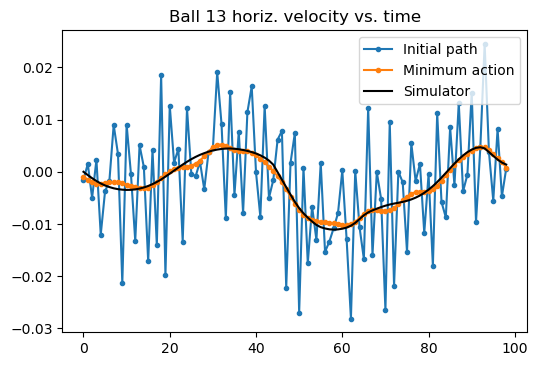

In [155]:
N = x_sim.shape[-2]
xs_before = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_after = xs_min[-1].detach().numpy().reshape(-1,N,2)

k = 25
plt.figure(dpi=100)
plt.title('Ball {} horiz. velocity vs. time'.format(1 + k//2))
plt.plot((xs_before[1:] - xs_before[:-1]).reshape(-1,N*2)[...,k], '.-', label='Initial path')
plt.plot((xs_after[1:] - xs_after[:-1]).reshape(-1,N*2)[...,k], '.-', label='Minimum action')
plt.plot((x_sim[1:] - x_sim[:-1]).reshape(-1,N*2)[...,k], 'k-', label='Simulator')
plt.legend()
plt.show()

In [156]:
xs = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=10)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/gas_action.pdf


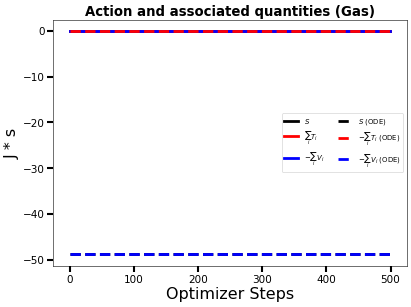

In [157]:
name = 'Gas'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels)
# plt.ylim(.1, -.1)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Ephemeris dataset and simulation

Loading ./data/ephemeris_ablate.csv...


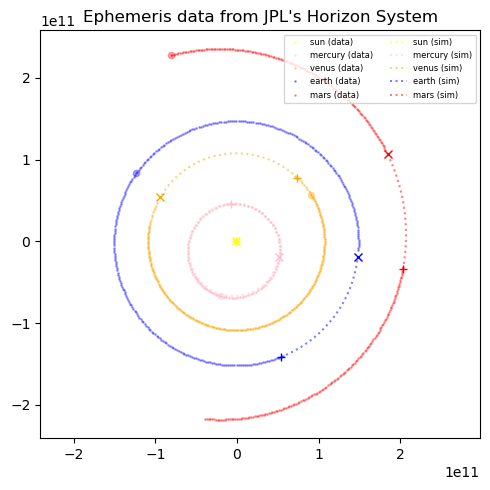

In [9]:
planets = ['sun', 'mercury', 'venus', 'earth', 'mars']
data_dir = './data/'
df = process_raw_ephemeris(planets, data_dir, last_n_days=365) #365

t_sim, x_sim = simulate_planets(df, planets)
plot_planets(df, planets)

colors = get_planet_colors()
for i, (planet, coords) in enumerate(zip(planets, x_sim.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (sim)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=2) ; plt.show()

In [19]:
dt = 24*60*60 ; N = len(planets)
df = process_raw_ephemeris(planets, data_dir, last_n_days=365)
t_sim, x_sim = simulate_planets(df, planets, dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e10, is_ephemeris=True) # [time, N*2]

L_planets = partial(lagrangian_planets, masses=get_masses(planets))

t_min, path, xs_min = minimize_action(init_path, steps=500, step_size=1e9,
                                       L_fn=L_planets, dt=dt, opt='adam')

Loading ./data/ephemeris_ablate.csv...
step=0000, S=1.259e+35 J*s, dt=0.0s
step=0033, S=1.955e+36 J*s, dt=0.5s
step=0066, S=4.602e+34 J*s, dt=0.5s
step=0099, S=6.424e+33 J*s, dt=0.5s
step=0132, S=4.069e+33 J*s, dt=0.5s
step=0165, S=3.906e+33 J*s, dt=0.5s
step=0198, S=3.843e+33 J*s, dt=0.5s
step=0231, S=3.803e+33 J*s, dt=0.5s
step=0264, S=3.780e+33 J*s, dt=0.5s
step=0297, S=3.766e+33 J*s, dt=0.5s
step=0330, S=3.758e+33 J*s, dt=0.5s
step=0363, S=3.754e+33 J*s, dt=0.5s
step=0396, S=3.752e+33 J*s, dt=0.5s
step=0429, S=3.751e+33 J*s, dt=0.5s
step=0462, S=3.751e+33 J*s, dt=0.5s
step=0495, S=3.750e+33 J*s, dt=0.5s


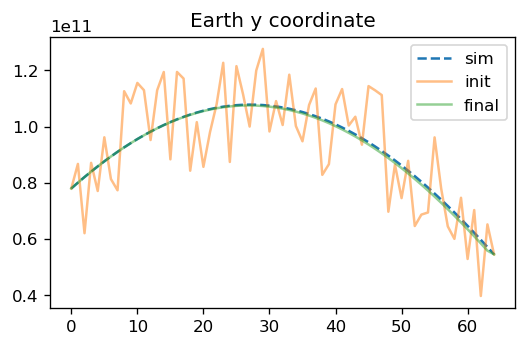

In [20]:
plt.figure(figsize=[5,3], dpi=120)
plt.title('Earth y coordinate')
xs_sim = init_path.x_true
xs_init = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_final = xs_min[-1].detach().numpy().reshape(-1,N,2)
plt.plot(xs_sim[:,2,1], '--', label='sim')
plt.plot(xs_init[:,2,1], alpha=0.5, label='init')
plt.plot(xs_final[:,2,1], alpha=0.5, label='final')
plt.legend()

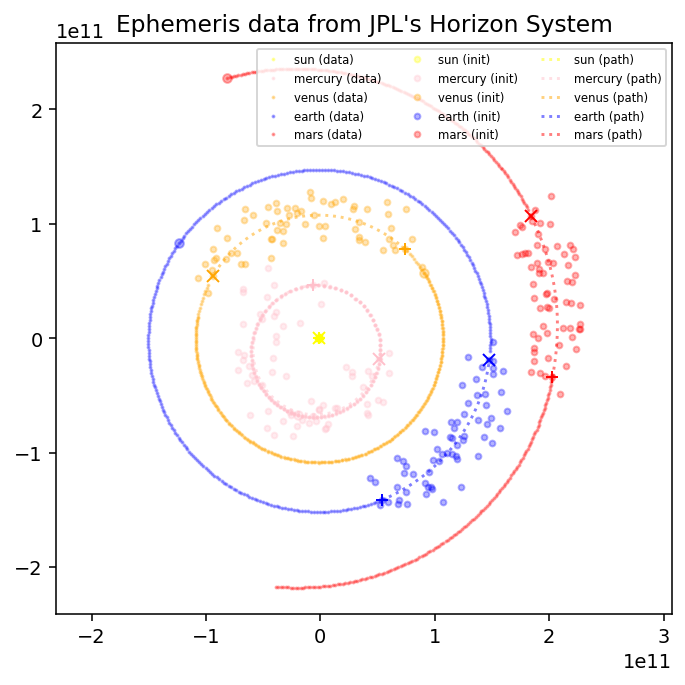

In [21]:
fig = plt.figure(figsize=[5,5], dpi=140)
plot_planets(df, planets, fig=fig)
colors = get_planet_colors()

xs = xs_min[0].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, '.', alpha=0.3, color=colors[planet], label=planets[i] + ' (init)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
    
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (path)')

plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=3) ; plt.show()